In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from xgboost import XGBRegressor
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')
import gc
import pickle
import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [58]:
# Plot feature importance 
def plot_features(booster):
    fig, ax = plt.subplots(1, 1, figsize= (10, 20))
    plot_importance(booster= booster, ax= ax)

In [3]:
# Load files
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv', index_col= 'ID')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')

### Outliers

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


 count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64


Text(0.5, 0.98, "Distribution of Item's price and sale")

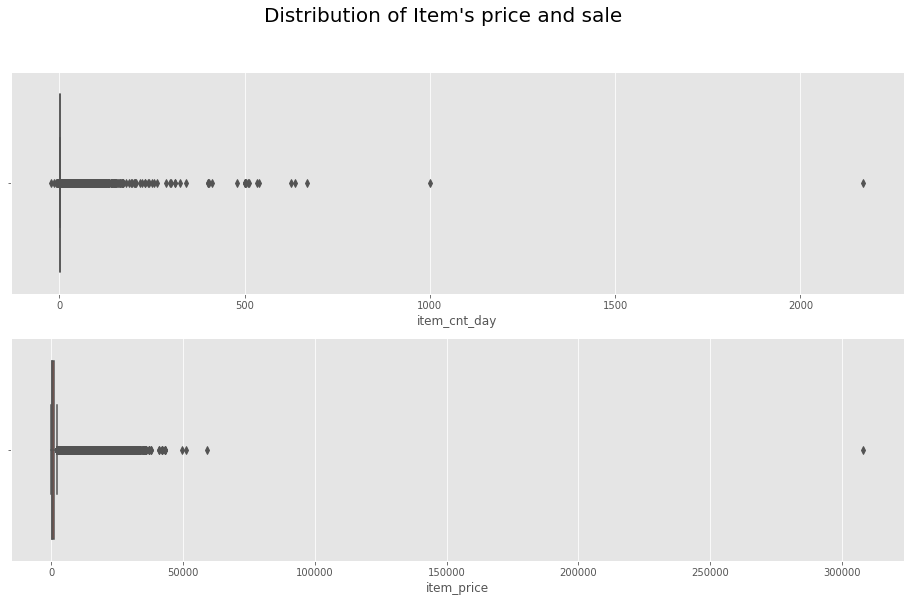

In [4]:
fig, ax = plt.subplots(nrows= 2, ncols= 1, figsize= (16, 9))

# Outliers in items sold per day
print(train['item_cnt_day'].describe())
sns.boxplot('item_cnt_day', data= train, ax= ax[0])

# Outliers in price of item in a particular day
print('\n\n', train['item_price'].describe())
sns.boxplot('item_price', data= train, ax= ax[1])
fig.suptitle('Distribution of Item\'s price and sale', fontsize= 20)

In [5]:
# Remove outliers and replace negative data with medians
train = train[train['item_cnt_day'] < 1001]
train = train[train['item_price'] < 100000]

In [6]:
# Find negative values
print(train[train['item_price'] < 0])

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0


In [7]:
median = train[(train['shop_id'] == 32) & (train['item_id'] == 2973) & (train['date_block_num'] == 4)\
              & (train['item_price'] > 0)]['item_price'].median()
train.loc[484683, 'item_price'] = median

In [8]:
# Fix duplicate shop names
# shop_ids are different but represents same shop
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

### Shops/Cats/Items data preprocessing

In [9]:
# shop names in 'shops' starts with the city name
# item categories in 'cats' contain type and subtype in its name

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split().apply(lambda x: x[0])

shops.loc[shops['city'] == '!Якутск', 'city'] == 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]



cats['type'] = cats['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['item_category_name'].str.split('-').apply(lambda x: x[1].strip() if len(x) > 1\
                                                                 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id', 'type_code', 'subtype_code']]



items.drop(['item_name'], axis= 1, inplace= True)

### Make train and test data same

In [10]:
new_items_test = len(list(set(test['item_id']) - set(test['item_id']).intersection(set(train['item_id']))))
print('There are {} new items in test set'.format(new_items_test))
print("Total items in test: ", len(test['item_id'].unique()))
print('Total shop/item pairs in test: ', len(test))

There are 363 new items in test set
Total items in test:  5100
Total shop/item pairs in test:  214200


In [11]:
# Make a matrix of all possible shop/item combination present in train
# Later merge test in this matrix to prevent data leakage, these values will be 0 for past months
matrix= []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train[train['date_block_num'] == i]
    matrix.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype= 'int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns= cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace= True)

In [12]:
matrix

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32
...,...,...,...
10768788,33,59,22162
10768978,33,59,22163
10769644,33,59,22164
10771170,33,59,22166


Aggregate the monthly sales of shop/item pairs in matrix data

In [13]:
monthly_sales = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
monthly_sales.columns = ['item_cnt_month']
monthly_sales.reset_index(inplace= True)


matrix = pd.merge(matrix, monthly_sales, on= cols, how= 'left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16)

In [14]:
# Append test to the matrix
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], axis= 0, ignore_index= True, sort= False, keys= cols)
matrix.fillna(0, inplace= True)

Append features from shops/Cats/Items

In [15]:
# Order is important here
matrix = pd.merge(matrix, shops, on= ['shop_id'], how= 'left')

matrix = pd.merge(matrix, items, on= ['item_id'], how= 'left')

In [16]:
matrix = pd.merge(matrix, cats, on= ['item_category_id'], how= 'left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [17]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,1,40,11,4
1,0,2,27,1.0,1,19,5,10
2,0,2,28,0.0,1,30,8,55
3,0,2,29,0.0,1,23,5,16
4,0,2,32,0.0,1,40,11,4
...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,21,55,13,2
11128000,34,45,16188,0.0,21,64,14,42
11128001,34,45,15757,0.0,21,55,13,2
11128002,34,45,19648,0.0,21,40,11,4


Now create lag Target lag features

In [18]:
# Function to create lag series
def lag_features(df, lags, col):
    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = temp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on= ['date_block_num', 'shop_id', 'item_id'], how= 'left')
    return df

In [19]:
# Create lag features for last 12 months
matrix = lag_features(matrix, [1, 2, 3, 6 ,12], 'item_cnt_month')

## Mean encoded features

In [20]:
# Average sale of each month
group = matrix.groupby('date_block_num').agg({'item_cnt_month': 'mean'})
group.columns= ['date_avg_item_cnt']
group.reset_index(inplace= True)

matrix = pd.merge(matrix, group, on= 'date_block_num', how= 'left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
# Create lag 1 series of avg sales of each month, this way we can capture the effect of previous month sale
# on the cuurent month

matrix = lag_features(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis= 1, inplace= True)

In [21]:
# Average sale of each item per month
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month':'mean'})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace= True)

matrix = pd.merge(matrix, group, on= ['date_block_num', 'item_id'], how= 'left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
# Create lags of this avegraged series to capture the effect of previous months sale of an item on the item sale 
# in current month
matrix = lag_features(matrix, [1, 2, 3, 6, 12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis= 1, inplace= True)

In [22]:
# Average sale in each shop per month
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace= True)

matrix = pd.merge(matrix, group, on= ['date_block_num', 'shop_id'], how= 'left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
# Create lags of this averaged series to capture the effect of previous months sale in a shop on the shop 
# sale in current month
matrix = lag_features(matrix, [1, 2, 3, 6, 12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis= 1, inplace= True)

In [23]:
# Similarly with the following categories
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace= True)

matrix = pd.merge(matrix, group, on= ['date_block_num', 'item_category_id'], how= 'left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)

matrix = lag_features(matrix, [1, 2, 3], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis= 1, inplace= True)

In [24]:
# Average shop/item_category sale each month
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': 'mean'})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace= True)

matrix = pd.merge(matrix, group, on= ['date_block_num', 'shop_id', 'item_category_id'], how= 'left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)

matrix = lag_features(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis= 1, inplace= True)

In [25]:
# Average shop/type sale each month
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': 'mean'})
group.columns= ['date_shop_type_avg_item_cnt']
group.reset_index(inplace= True)

matrix = pd.merge(matrix, group, on= ['date_block_num', 'shop_id', 'type_code'], how= 'left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_features(matrix, [1, 6], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis= 1, inplace= True)

In [26]:
# Average shop/subtype sale each month
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': 'mean'})
group.columns= ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace= True)

matrix = pd.merge(matrix, group, on= ['date_block_num', 'shop_id', 'subtype_code'], how= 'left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_features(matrix, [1, 6], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis= 1, inplace= True)

In [27]:
# Average city sale each month
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)

matrix = lag_features(matrix, [1, 6, 12], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [28]:
# Avreage item/city sale each month
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_features(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [29]:
# Average type sale each month
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_features(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [30]:
# Average subtype sale each month
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)

matrix = lag_features(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

## Features derived from trend

In [31]:
# Here trend refers to the change in quantity over time
# Eg: if we take lags of average price of an item each month and take percentage change from each lag 
# w.r.t a refernce level, mostly the mean sales of that item over the whole time period. 
#This way we capture the effect of price change in 
# previous months on the sale of current month.

## Price trend of last six months

In [32]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)


group = train.groupby(['date_block_num', 'item_id']).agg({'item_price': 'mean'})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace= True)

matrix = pd.merge(matrix, group, on= ['date_block_num', 'item_id'], how= 'left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags= [1, 2, 3, 4, 5, 6]
matrix = lag_features(matrix, lags, 'date_item_avg_item_price')

# Calculate pct_change in avg price of each item per month
for i in lags:
    matrix['delta_price_lag_'+str(i)] = (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price'])\
    /matrix['item_avg_item_price']
  

In [33]:
matrix.filter(regex= '^delta_price|date_block_num')

,date_block_num,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6
0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11127999,34,-0.475098,-0.475098,-0.475098,-0.475098,-0.475586,0.054993
11128000,34,0.081116,-0.027054,NaN,NaN,NaN,NaN
11128001,34,0.155884,0.155884,0.155884,0.155884,0.155884,0.050476
11128002,34,-0.091736,0.008919,-0.033112,0.008919,0.008919,0.008919


In [34]:
def select_trend(row): # take any trend from last six months as the final trend 
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis= 1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    to_drop += ['delta_price_lag_'+str(i)]
matrix.drop(to_drop, axis= 1, inplace= True)

In [35]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_6,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_12,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,2,19,0.0,1,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0,2,27,1.0,1,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,0,2,28,0.0,1,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,0,2,29,0.0,1,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,0,2,32,0.0,1,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,21,55,13,2,1.0,0.0,0.0,0.0,NaN,0.258545,0.045441,0.023254,0.071411,0.590820,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.196899,0.177612,0.217285,0.126831,0.089294,0.088013,0.126831,0.127563,0.135376,0.143433,NaN,0.5,0.146973,0.196899,-0.475098
11128000,34,45,16188,0.0,21,64,14,42,0.0,0.0,NaN,NaN,NaN,0.258545,0.022720,0.069763,NaN,NaN,NaN,0.126709,0.128784,NaN,NaN,NaN,0.155884,0.167847,NaN,0.094482,0.106201,NaN,0.094482,NaN,0.135376,NaN,NaN,0.0,0.237305,0.155884,0.081116
11128001,34,45,15757,0.0,21,55,13,2,0.0,0.0,0.0,0.0,0.0,0.258545,0.113647,0.069763,0.095215,0.250000,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.196899,0.177612,0.217285,0.126831,0.089294,0.088013,0.126831,0.127563,0.135376,0.143433,0.182007,0.0,0.146973,0.196899,0.155884
11128002,34,45,19648,0.0,21,40,11,4,0.0,0.0,0.0,0.0,NaN,0.258545,0.045441,0.069763,0.166626,0.090881,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.220825,0.200928,0.242188,0.083740,0.097046,0.077515,0.083740,0.082214,0.135376,0.143433,NaN,0.0,0.224243,0.220825,-0.091736


### Trend of last month  shop revenue 


In [36]:
train['revenue'] = train['item_price']*train['item_cnt_day']
# Calculate avg revenue of each shop each month
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# Calculate avg revenue of each shop 'per' month
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_features(matrix, [1], 'delta_revenue') # if we take this lag before computing the trend 
# like we did in price trend, then it would be exactly same with same final result
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

## More features to consider

In [37]:
matrix['month'] = matrix['date_block_num']% 12

In [38]:
days = {0:31,
       1:28,
       2:31,
       3:30,
       4:31,
       5:30,
       6:31,
       7:31,
       8:30,
       9:31,
       10:30,
       11:31}
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months elapsed since last sale for each shop/item pair and for item only

In [1]:
# Months passed since last sale for each shop/item pair
"""cache = {}
matrix['last_shop_item_sale'] = -1
matrix['last_shop_item_sale'] = matrix['last_shop_item_sale'].astype(np.int8)

for idx, row in matrix.iterrows():
    key = str(row['item_id'])+' '+str(row['shop_id'])
    if key not in cache:
        if row['item_cnt_month'] != 0:
            cache[key] = row['date_block_num']
    else:
        last_sold = cache[key]
        matrix.loc[idx, 'last_shop_item_sale'] = row['date_block_num'] - last_sold
        cache[key] = row['date_block_num']"""

# could not run this because of system constrains

"cache = {}\nmatrix['last_shop_item_sale'] = -1\nmatrix['last_shop_item_sale'] = matrix['last_shop_item_sale'].astype(np.int8)\n\nfor idx, row in matrix.iterrows():\n    key = str(row['item_id'])+' '+str(row['shop_id'])\n    if key not in cache:\n        if row['item_cnt_month'] != 0:\n            cache[key] = row['date_block_num']\n    else:\n        last_sold = cache[key]\n        matrix.loc[idx, 'last_shop_item_sale'] = row['date_block_num'] - last_sold\n        cache[key] = row['date_block_num']"

In [ ]:
# Months passed since last sale for each item
"""cache= {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row['item_id'])
    if key not in cache:
        if row['item_cnt_month']!= 0:
            cache[key] = row['date_block_num']
    else:
        last_sold = cache[key]
        matrix.loc[idx, 'item_last_sale'] = row['date_block_num'] - last_sold
        cache[key] = row['date_block_num']"""

# could not run this because of system constrains

# Final preparations

Since we used 12 as lag values so we have to drop first 12 months as lag 12 doesn't exist for them.

Producing lag features brings lot of null values, remove them too

In [41]:
matrix = matrix[matrix['date_block_num'] > 11]

In [42]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace= True)
    return df

matrix = fill_na(matrix)

In [43]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_6',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_6', 'date_city_avg_item_cn

In [47]:
matrix.to_pickle('data.pkl')
del matrix
del monthly_sales
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# XGBoost

In [48]:
data = pd.read_pickle('data.pkl')

In [ ]:
data.columns

In [49]:
# select features
data = data[
    ['date_block_num',
     'shop_id',
     'item_id',
     'item_cnt_month',
     'city_code',
     'item_category_id',
     'type_code',
     'subtype_code',
     'item_cnt_month_lag_1',
     'item_cnt_month_lag_2',
     'item_cnt_month_lag_3',
     'item_cnt_month_lag_6',
     'item_cnt_month_lag_12',
     'date_avg_item_cnt_lag_1',
     'date_item_avg_item_cnt_lag_1',
     'date_item_avg_item_cnt_lag_2',
     'date_item_avg_item_cnt_lag_3',
     'date_item_avg_item_cnt_lag_6',
     'date_item_avg_item_cnt_lag_12',
     'date_shop_avg_item_cnt_lag_1',
     'date_shop_avg_item_cnt_lag_2',
     'date_shop_avg_item_cnt_lag_3',
     'date_shop_avg_item_cnt_lag_6',
     'date_shop_avg_item_cnt_lag_12',
     'date_cat_avg_item_cnt_lag_1',
     'date_cat_avg_item_cnt_lag_2',
     'date_cat_avg_item_cnt_lag_3',
     'date_shop_cat_avg_item_cnt_lag_1',
     'date_shop_type_avg_item_cnt_lag_1',
     'date_shop_type_avg_item_cnt_lag_6',
     'date_shop_subtype_avg_item_cnt_lag_1',
     'date_shop_subtype_avg_item_cnt_lag_6',
     'date_city_avg_item_cnt_lag_1',
     'date_city_avg_item_cnt_lag_6',
     'date_city_avg_item_cnt_lag_12',
     'date_item_city_avg_item_cnt_lag_1',
     'date_type_avg_item_cnt_lag_1',
     'date_subtype_avg_item_cnt_lag_1',
     'delta_price_lag',
     'delta_revenue_lag_1',
     'month',
     'days',
     #'last_shop_item_sale'
    ]
]

# Validation strategy
13-32 months are for training
33th month for validaion
34th month is the test set

In [50]:
# train data
X_train = data[data['date_block_num'] < 33].drop(['item_cnt_month'], axis= 1)
y_train = data[data['date_block_num'] < 33].item_cnt_month

# validation data
X_val = data[data['date_block_num'] == 33].drop(['item_cnt_month'], axis= 1)
y_val = data[data['date_block_num'] == 33].item_cnt_month

# test data
X_test = data[data['date_block_num'] == 34].drop(['item_cnt_month'], axis= 1)
y_test = data[data['date_block_num'] == 34].item_cnt_month

In [51]:
del data
gc.collect()

20

In [54]:
model = XGBRegressor(
    max_depth= 8,
    n_estimators= 1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42
)

model.fit(
    X_train,
    y_train,
    eval_metric= 'rmse',
    eval_set= [(X_train, y_train), (X_val, y_val)],
    verbose= True,
    early_stopping_rounds= 10
)

[18:33:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06345	validation_1-rmse:1.05730
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.98101	validation_1-rmse:1.00193
[2]	validation_0-rmse:0.93194	validation_1-rmse:0.96737
[3]	validation_0-rmse:0.90310	validation_1-rmse:0.95353
[4]	validation_0-rmse:0.88608	validation_1-rmse:0.94573
[5]	validation_0-rmse:0.87338	validation_1-rmse:0.93869
[6]	validation_0-rmse:0.86596	validation_1-rmse:0.93714
[7]	validation_0-rmse:0.85895	validation_1-rmse:0.93818
[8]	validation_0-rmse:0.85454	validation_1-rmse:0.93659
[9]	validation_0-rmse:0.85140	validation_1-rmse:0.93559
[10]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method='approx', validate_parameters=1, verbosity=None)

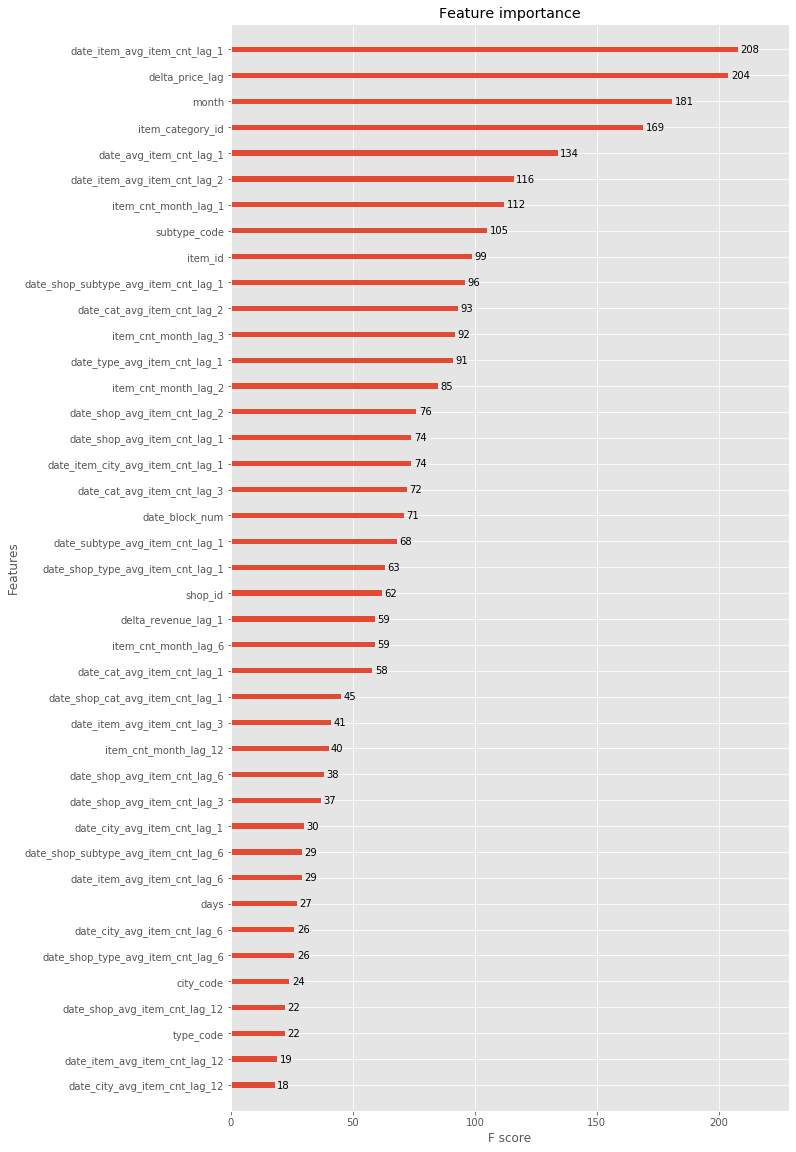

In [59]:
# Plot feature importances
plot_features(model)

In [60]:
# Predictions
y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    'ID': test.index,
    'item_cnt_month': y_test
})

# Submission
submission.to_csv('xgb_submission.csv', index= False)